### **Part 1 – Problem Definition & Data Collection**

#### **1.1 Problem Definition**

The goal of this project is to build a machine learning classification model that predicts whether a chemical compound is **mutagenic or non-mutagenic** based solely on its molecular structure.

##### **Why is this important?**
Ames mutagenicity is a critical early-stage toxicity endpoint in drug discovery and chemical safety assessment. Experimental Ames testing is time-consuming, resource-intensive, and cannot be performed for every candidate compound in large chemical libraries. Computational toxicity prediction models can rapidly screen compounds, identify potential safety liabilities early, and reduce unnecessary experimental testing, thereby improving efficiency in ADMET-driven decision making.

##### **Dataset**
This project uses a publicly available Ames mutagenicity benchmark dataset.

- **Input:** Molecular structures represented as SMILES strings  
- **Output:** Binary classification label  
  - `1` = Mutagenic  
  - `0` = Non-mutagenic  
- The dataset is approximately balanced between the two classes.
- Molecular features (physicochemical descriptors and fingerprints) are generated using RDKit.
- Invalid or non-parsable SMILES are removed prior to feature generation.
- A **scaffold-aware Train/Test split** is constructed to ensure chemically realistic model evaluation.

##### **Objective**
The objective is to develop and evaluate QSAR-based classification models that can generalize to **previously unseen chemical scaffolds**, rather than memorizing closely related compounds. Model performance is assessed using metrics appropriate for toxicity prediction, including:

- ROC-AUC (global discrimination)
- PR-AUC (primary metric for positive class behavior)
- Precision and Recall for the mutagenic class
- F1-score
- Accuracy


#### **1.2 Data Collection**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Crippen, Lipinski, rdMolDescriptors, rdFingerprintGenerator
from rdkit.Chem.MolStandardize import rdMolStandardize

In [14]:
# Load dataset
df = pd.read_csv(r"C:\Users\nezih\Mutagenicity_N6512.csv")
df.head()

,CAS_NO,Source,Activity,Steroid,WDI,Canonical_Smiles,REFERENCE
0,2475-33-4,VITIC,0,-1,NaN,O=C1c2ccccc2C(=O)c3c1ccc4c3[nH]c5c6C(=O)c7cccc...,"JUDSON, PN, COOKE, PA, DOERRER, NG, GREENE, N,..."
1,820-75-7,CCRIS,1,-1,NaN,NNC(=O)CNC(=O)\C=N\#N,"MCCANN,J, CHOI,E, YAMASAKI,E AND AMES,BN, DETE..."
2,2435-76-9,CCRIS,1,-1,NaN,O=C1NC(=O)\C(=N/#N)\C=N1,"HIRAMOTO,K, KATO,T AND KIKUGAWA,K, MECHANISMS ..."
3,817-99-2,CCRIS,1,-1,NaN,NC(=O)CNC(=O)\C=N\#N,"MCCANN,J, CHOI,E, YAMASAKI,E AND AMES,BN, DETE..."
4,116539-70-9,CCRIS,1,-1,NaN,CCCCN(CC(O)C1=C\C(=N/#N)\C(=O)C=C1)N=O,"KIKUGAWA,K, KATO,T AND TAKEDA,Y, FORMATION OF ..."


### **Part 2 – Exploratory Data Analysis (EDA)**

#### **2.1 Dataset Overview**

In [15]:
# Check basic dataset info
print("Shape:", df.shape)
print("Columns:", df.columns)

Shape: (6512, 7)
Columns: Index(['CAS_NO', 'Source', 'Activity', 'Steroid', 'WDI', 'Canonical_Smiles',
       'REFERENCE'],
      dtype='object')


In [16]:
# Check datatypes
print(df.dtypes)

CAS_NO              object
Source              object
Activity             int64
Steroid              int64
WDI                 object
Canonical_Smiles    object
REFERENCE           object
dtype: object


In [17]:
# Check for missing values
print(df.isnull().sum())

CAS_NO                 0
Source                 0
Activity               0
Steroid                0
WDI                 5096
Canonical_Smiles       0
REFERENCE              0
dtype: int64


In [18]:
# Target distribution
print(df["Activity"].value_counts())
print(df["Activity"].value_counts(normalize=True).round(3))

Activity
1    3503
0    3009
Name: count, dtype: int64
Activity
1    0.538
0    0.462
Name: proportion, dtype: float64


In [19]:
# Duplicate check
print("Unique SMILES:", df['Canonical_Smiles'].nunique())
print("Total rows:", len(df))
print("Duplicate SMILES:", len(df) - df['Canonical_Smiles'].nunique())

Unique SMILES: 6512
Total rows: 6512
Duplicate SMILES: 0


In [20]:
# Invalid SMILES check
from rdkit import Chem
invalid = df['Canonical_Smiles'].apply(lambda x: Chem.MolFromSmiles(x) is None).sum()
print("Invalid SMILES:", invalid)

[21:46:04] SMILES Parse Error: syntax error while parsing: NNC(=O)CNC(=O)\C=N\#N
[21:46:04] SMILES Parse Error: check for mistakes around position 20:
[21:46:04] NNC(=O)CNC(=O)\C=N\#N
[21:46:04] ~~~~~~~~~~~~~~~~~~~~^
[21:46:04] SMILES Parse Error: Failed parsing SMILES 'NNC(=O)CNC(=O)\C=N\#N' for input: 'NNC(=O)CNC(=O)\C=N\#N'
[21:46:04] SMILES Parse Error: syntax error while parsing: O=C1NC(=O)\C(=N/#N)\C=N1
[21:46:04] SMILES Parse Error: check for mistakes around position 17:
[21:46:04] O=C1NC(=O)\C(=N/#N)\C=N1
[21:46:04] ~~~~~~~~~~~~~~~~^
[21:46:04] SMILES Parse Error: extra open parentheses while parsing: O=C1NC(=O)\C(=N/#N)\C=N1
[21:46:04] SMILES Parse Error: check for mistakes around position 13:
[21:46:04] O=C1NC(=O)\C(=N/#N)\C=N1
[21:46:04] ~~~~~~~~~~~~^
[21:46:04] SMILES Parse Error: Failed parsing SMILES 'O=C1NC(=O)\C(=N/#N)\C=N1' for input: 'O=C1NC(=O)\C(=N/#N)\C=N1'
[21:46:04] SMILES Parse Error: syntax error while parsing: NC(=O)CNC(=O)\C=N\#N
[21:46:04] SMILES Parse Error

Invalid SMILES: 6


In [23]:
# Delete invalid SMILES
from rdkit import RDLogger

# Disable RDKit error logs
RDLogger.DisableLog("rdApp.error")

def is_valid_smiles(smiles):
    """Return True if RDKit can parse the SMILES string."""
    return Chem.MolFromSmiles(smiles) is not None

# Create a clean modeling dataset by removing invalid SMILES
df_model = df[df["Canonical_Smiles"].apply(is_valid_smiles)].copy()
df_model = df_model.reset_index(drop=True)

print("Original df shape:", df.shape)
print("df_model shape after removing invalid SMILES:", df_model.shape)


Original df shape: (6512, 7)
df_model shape after removing invalid SMILES: (6506, 7)


The original dataset was preserved as a raw reference table. Six SMILES strings that could not be parsed by RDKit were identified and removed, and a separate modeling dataset was created. This ensures that only chemically valid molecules are used for feature generation and model training while maintaining traceability to the original data.

#### Chemical Standardization Strategy

Although comprehensive chemical standardization pipelines (such as fragment removal, uncharging, tautomer canonicalization, and stereochemistry normalization) are commonly applied when working with raw data sources like PubChem or ChEMBL, they are not strictly required for the Ames mutagenicity benchmark dataset used in this project.

This dataset is a curated and widely used benchmark and provides canonical SMILES representations with a high level of structural consistency. During data quality control, no duplicate or conflicting SMILES were observed. All structures were evaluated for RDKit parsability, and only six SMILES strings could not be parsed and were removed prior to modeling.

Given the curated nature of the dataset, aggressive normalization steps such as charge neutralization or tautomer canonicalization were intentionally avoided. Such transformations may remove chemically meaningful information and introduce unnecessary alterations in structure–toxicity relationships.

Therefore, chemical preprocessing in this project was limited to RDKit-based SMILES validation and the use of canonical SMILES as provided, ensuring a balance between data cleanliness and preservation of relevant chemical information.

#### **2.2 Visualization of Sample Molecules with Class Labels (RDKit)**

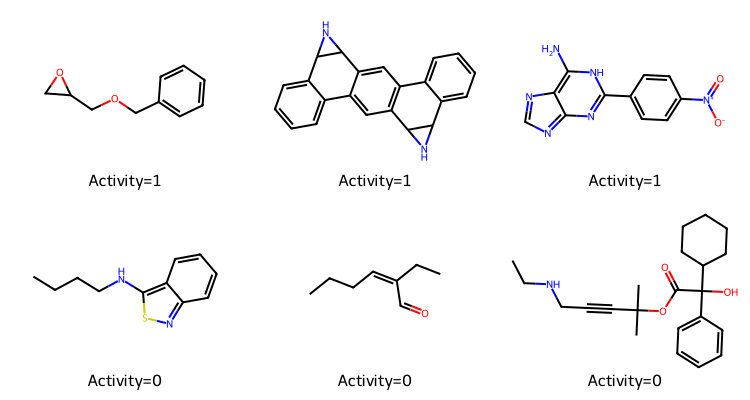

In [24]:
# Visualize a small random sample of molecules with class labels (RDKit)

from rdkit.Chem.Draw import MolsToGridImage

# Pick a small, balanced random sample
pos = df_model[df_model["Activity"] == 1].sample(n=3, random_state=42)
neg = df_model[df_model["Activity"] == 0].sample(n=3, random_state=42)
sample_df = pd.concat([pos, neg], ignore_index=True)

# Convert SMILES -> RDKit Mol objects
mols, legends = [], []
for _, row in sample_df.iterrows():
    mol = Chem.MolFromSmiles(row["Canonical_Smiles"])
    if mol is None:
        continue
    mols.append(mol)
    legends.append(f"Activity={row['Activity']}")

# Draw a grid image
img = MolsToGridImage(
    mols,
    molsPerRow=3,
    subImgSize=(250, 200),
    legends=legends
)

img


A small balanced random subset of molecules from each class was visualized using RDKit to verify correct SMILES parsing and label assignment. This step serves as a qualitative sanity check rather than a structural analysis.

#### **2.3 Calculation of Lipinski's Drug-Likeness Descriptors**

In [27]:
# Function: compute Lipinski descriptors for a molecule

# Create RDKit Mol objects
df_model["mol"] = df_model["Canonical_Smiles"].apply(Chem.MolFromSmiles)

def compute_lipinski_descriptors(mol):
    if mol is None:
        return pd.Series({
            "MolWt": None,
            "MolLogP": None,
            "HBD": None,
            "HBA": None,
            "TPSA": None,
            "RotatableBonds": None
        })
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),                       # Molecular weight
        "MolLogP": Crippen.MolLogP(mol),                       # LogP
        "HBD": Lipinski.NumHDonors(mol),                       # H-bond donors
        "HBA": Lipinski.NumHAcceptors(mol),                    # H-bond acceptors
        "TPSA": rdMolDescriptors.CalcTPSA(mol),                # Polar surface area
        "RotatableBonds": rdMolDescriptors.CalcNumRotatableBonds(mol)  # Rotatable bonds
    })

# Compute descriptors
df_lipinski = df_model["mol"].apply(compute_lipinski_descriptors)

# Quick check
print(df_lipinski.head())

     MolWt  MolLogP  HBD  HBA    TPSA  RotatableBonds
0  646.614  6.34940  2.0  6.0  134.00             0.0
1  406.906  3.94560  0.0  5.0   69.67             2.0
2  126.123 -1.38180  3.0  6.0  116.73             0.0
3  307.309  5.17742  1.0  5.0   88.09             3.0
4  234.324  3.28090  1.0  3.0   41.99             3.0


#### **2.4 Combine Molecule Dataset and Lipinski Features**

In [29]:
# Check if both DataFrames have exactly the same index
if df_model.index.equals(df_lipinski.index):
    print("✅ Index match perfectly – safe to concat without reset_index.")
else:
    print("⚠️ Index do NOT match – better use reset_index(drop=True).")

# Combine original molecule data with Lipinski descriptors
df_combined = pd.concat([df_model, df_lipinski], axis=1)

df_combined.head()

✅ Index match perfectly – safe to concat without reset_index.


,CAS_NO,Source,Activity,Steroid,WDI,Canonical_Smiles,REFERENCE,mol,MolWt,MolLogP,HBD,HBA,TPSA,RotatableBonds
0,2475-33-4,VITIC,0,-1,NaN,O=C1c2ccccc2C(=O)c3c1ccc4c3[nH]c5c6C(=O)c7cccc...,"JUDSON, PN, COOKE, PA, DOERRER, NG, GREENE, N,...",<rdkit.Chem.rdchem.Mol object at 0x000001D4688...,646.614,6.34940,2.0,6.0,134.00,0.0
1,105149-00-6,CCRIS,0,-1,NaN,CC(=O)OC1(CCC2C3C=C(Cl)C4=CC(=O)OCC4(C)C3CCC12...,"TANIFUJI,H, HISADA,S, MORIHIRA,M, EGUCHI,K, KU...",<rdkit.Chem.rdchem.Mol object at 0x000001D4688...,406.906,3.94560,0.0,5.0,69.67,2.0
2,108-78-1,VITIC,0,-1,MELAMINE,Nc1nc(N)nc(N)n1,"JUDSON, PN, COOKE, PA, DOERRER, NG, GREENE, N,...",<rdkit.Chem.rdchem.Mol object at 0x000001D4688...,126.123,-1.38180,3.0,6.0,116.73,0.0
3,2425-85-6,EPA2,1,-1,DR0034231,Cc1ccc(N=Nc2c(O)ccc3ccccc23)c(c1)[N+](=O)[O-],"HELMA, C, CRAMER, T, KRAMER, S, AND DE RAEDT, ...",<rdkit.Chem.rdchem.Mol object at 0x000001D4688...,307.309,5.17742,1.0,5.0,88.09,3.0
4,67019-24-3,CCRIS,0,-1,NaN,CC(C)CC(=O)Nc1snc2ccccc12,"ZANI,F, BELLOTTI,A AND MAZZA,P, BIOLOGICAL STU...",<rdkit.Chem.rdchem.Mol object at 0x000001D4688...,234.324,3.28090,1.0,3.0,41.99,3.0


#### **2.5 Descriptor Quality Control**

In [30]:
# Descriptor quality check (Lipinski)
desc_cols = ["MolWt", "MolLogP", "HBD", "HBA", "TPSA", "RotatableBonds"]

print("Missing values per descriptor:")
print(df_combined[desc_cols].isna().sum())

print("\nInfinite values per descriptor:")
print(np.isinf(df_combined[desc_cols].to_numpy(dtype=float)).sum(axis=0))

summary = df_combined[desc_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
summary = summary[["count", "mean", "std", "min", "1%", "5%", "50%", "95%", "99%", "max"]]
print("\nDescriptor summary statistics:")
print(summary)

group_stats = df_combined.groupby("Activity")[desc_cols].agg(["mean", "median"])
print("\nClass-wise descriptor stats (mean/median):")
print(group_stats)

Missing values per descriptor:
MolWt             0
MolLogP           0
HBD               0
HBA               0
TPSA              0
RotatableBonds    0
dtype: int64

Infinite values per descriptor:
[0 0 0 0 0 0]

Descriptor summary statistics:
                 count        mean         std     min        1%         5%  \
MolWt           6506.0  247.631475  134.714315  26.018  62.23185  99.162750   
MolLogP         6506.0    2.549512    2.053452 -20.770  -2.07068  -0.482675   
HBD             6506.0    1.095758    1.692745   0.000   0.00000   0.000000   
HBA             6506.0    3.274055    2.801569   0.000   0.00000   0.000000   
TPSA            6506.0   56.900765   52.875670   0.000   0.00000   0.000000   
RotatableBonds  6506.0    2.865355    3.751055   0.000   0.00000   0.000000   

                     50%        95%        99%        max  
MolWt           229.2805  449.92025  742.53070  3080.4980  
MolLogP           2.4366    5.80890    7.92727    17.8539  
HBD               1.000

Lipinski descriptors were inspected for missing values, numerical stability, and reasonable physical ranges. No missing or infinite values were observed. While heavy-tailed distributions and extreme values were present, no descriptor-based filtering was applied, as these outliers are inherent to the Ames benchmark and were handled through feature scaling.

#### **2.6 Correlation Heatmap of Molecular Descriptors**

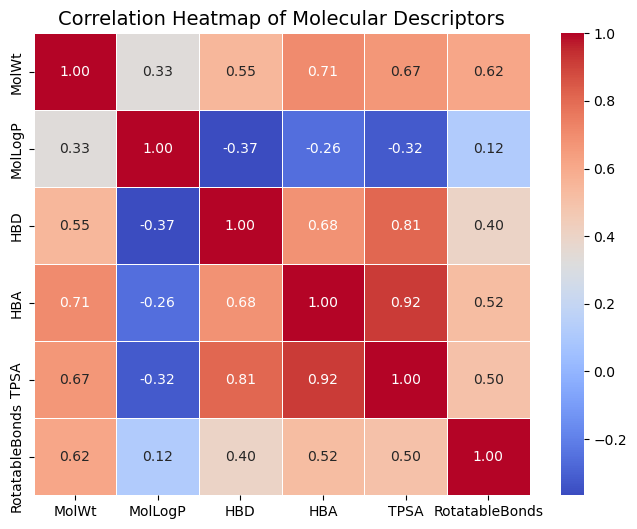

In [31]:
# Descriptor columns to include in correlation
desc_cols = ["MolWt", "MolLogP", "HBD", "HBA", "TPSA", "RotatableBonds"]

# Compute correlation matrix
corr_matrix = df_combined[desc_cols].corr(method="pearson")

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Molecular Descriptors", fontsize=14)
plt.show()

#### Interpretation of Descriptor Correlations

The correlation heatmap shows expected relationships between basic molecular descriptors. Strong positive correlations are observed between HBA and TPSA (r = 0.92) and between HBD and TPSA (r = 0.81), which is chemically intuitive because polar surface area is largely influenced by hydrogen bond donors and acceptors. Molecular weight also shows moderate correlation with several descriptors, indicating that larger molecules tend to have more functional groups and higher polarity.

MolLogP shows weaker correlations with most other descriptors, suggesting that lipophilicity provides complementary information rather than duplicating size or polarity effects. Overall, the observed correlations are chemically reasonable and confirm that the descriptors are consistent and suitable for downstream modeling.


### **Part 3 – Feature Engineering / Descriptor Calculation**

#### **3.1 Morgan Fingerprints (ECFP4)**

In [32]:
#  Morgan fingerprint (ECFP4, radius=2, 2048 bits) for Ames dataset

gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

def morgan_fp_bits(smiles: str) -> np.ndarray:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(2048, dtype=np.uint8)
    fp = gen.GetFingerprint(mol)
    arr = np.zeros(2048, dtype=np.uint8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr
    
X_fp = np.vstack(df_combined["Canonical_Smiles"].apply(morgan_fp_bits).values)

print("X_fp shape:", X_fp.shape)  


X_fp shape: (6506, 2048)


In [33]:
# Convert to DataFrame
fp_columns = [f"FP_{i}" for i in range(X_fp.shape[1])]
fp_df = pd.DataFrame(X_fp, columns=fp_columns, index=df_combined.index)

fp_df.head()


,FP_0,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### **3.2 Preparing Final Descriptor Set for Modeling**

In [36]:
# 1) Define candidate descriptor columns (Lipinski-like block)
desc_all = ["MolWt", "MolLogP", "HBD", "HBA", "TPSA", "RotatableBonds"]

# 2) Keep only those that actually exist in df_combined
desc_cols = [c for c in desc_all if c in df_combined.columns]
print("Using descriptor columns:", desc_cols)

# 3) Sanity check: at least one descriptor must be present
assert len(desc_cols) > 0, "No descriptor columns found in df_combined!"

# 4) Build descriptor matrix X_desc and labels y (Ames label column is 'Activity')
X_desc = df_combined[desc_cols].astype(float).to_numpy()
y = df_combined["Activity"].astype(int).to_numpy()

# 5) Hybrid feature matrix: descriptors + fingerprints
# Note: X_fp must have the same row order as df_combined
assert X_desc.shape[0] == X_fp.shape[0], "Row count mismatch between X_desc and X_fp!"

X_hybrid = np.hstack([X_desc, X_fp])

print("X_desc:", X_desc.shape)
print("X_fp:", X_fp.shape)
print("X_hybrid:", X_hybrid.shape)
print("y:", y.shape)

Using descriptor columns: ['MolWt', 'MolLogP', 'HBD', 'HBA', 'TPSA', 'RotatableBonds']
X_desc: (6506, 6)
X_fp: (6506, 2048)
X_hybrid: (6506, 2054)
y: (6506,)


#### **3.3 Train-Test Split**

**Murcko scaffold** represents the core ring systems and linkers of a molecule after removing peripheral substituents. **Scaffold-based splitting** groups molecules by their shared chemical backbone and assigns entire scaffolds exclusively to either the training or test set. This strategy prevents structural information **leakage** caused by closely related compounds appearing in both sets and provides a more realistic evaluation of model generalization, which is particularly important in QSAR and ADMET modeling.

In [37]:
# Scaffold-based Train / Test split (Murcko)

from rdkit.Chem.Scaffolds import MurckoScaffold

def murcko_scaffold(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)

# 1) Compute scaffolds from canonical SMILES
scaff = df_combined["Canonical_Smiles"].apply(murcko_scaffold)

# 2) Drop rows with invalid scaffolds (rare, but safe)
valid_mask = scaff.notna().to_numpy()
dfv = df_combined.loc[valid_mask].copy()

Xv = X_hybrid[valid_mask]
yv = dfv["Activity"].astype(int).to_numpy()
scaff_v = scaff.loc[valid_mask].to_numpy()

# 3) Group indices by scaffold (indices are positions within dfv/Xv)
scaf_to_idx = {}
for i, s in enumerate(scaff_v):
    scaf_to_idx.setdefault(s, []).append(i)

# 4) Sort scaffold groups (largest first) for a deterministic split
groups = list(scaf_to_idx.values())
groups = sorted(groups, key=lambda g: (-len(g), g[0]))  # size desc, then stable

# 5) Allocate groups to Test, then Train (scaffold-level)
test_frac = 0.20
n_total = len(yv)
n_test_target = int(np.floor(test_frac * n_total))

test_idx, train_idx = [], []

for g in groups:
    if len(test_idx) + len(g) <= n_test_target:
        test_idx.extend(g)
    else:
        train_idx.extend(g)

# 6) Build final splits
X_train, y_train = Xv[train_idx], yv[train_idx]
X_test,  y_test  = Xv[test_idx],  yv[test_idx]

print("Scaffold split sizes:")
print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape,  y_test.shape)

# 7) Verify no scaffold leakage
train_scaf = set(scaff_v[train_idx])
test_scaf  = set(scaff_v[test_idx])

print("\nScaffold overlap checks (should be 0):")
print("Train ∩ Test:", len(train_scaf & test_scaf))

# 8) Keep the corresponding rows as DataFrames
df_train = dfv.iloc[train_idx].copy()
df_test  = dfv.iloc[test_idx].copy()


Scaffold split sizes:
Train: (5205, 2054) (5205,)
Test:  (1301, 2054) (1301,)

Scaffold overlap checks (should be 0):
Train ∩ Test: 0


#### **Compare class distribution (Activity) in Train vs Test** 

In [38]:
# Compare class distribution (Activity) in Train vs Test

def class_distribution(series):
    counts = series.value_counts().sort_index()
    props = series.value_counts(normalize=True).sort_index()
    out = pd.DataFrame({"count": counts, "proportion": props.round(3)})
    return out

print("Train Activity distribution:")
print(class_distribution(df_train["Activity"]))

print("\nTest Activity distribution:")
print(class_distribution(df_test["Activity"]))

Train Activity distribution:
          count  proportion
Activity                   
0          2295       0.441
1          2910       0.559

Test Activity distribution:
          count  proportion
Activity                   
0           714       0.549
1           587       0.451


After scaffold-based splitting, the class distribution remains reasonably balanced in both training and test sets. Minor differences in class proportions are expected due to scaffold-level grouping and are acceptable in the context of preventing structural information leakage.


#### **3.4 Feature Scaling (Descriptor-Only Standardization)**

In [39]:
# Scale Lipinski descriptors (train-only fit)

from sklearn.preprocessing import StandardScaler

# Number of descriptor columns (Lipinski block)
n_desc = len(desc_cols)  # should be 6

# Split hybrid matrix back into descriptor + fingerprint blocks
X_train_desc = X_train[:, :n_desc]
X_train_fp   = X_train[:, n_desc:]

X_test_desc  = X_test[:, :n_desc]
X_test_fp    = X_test[:, n_desc:]

# Fit scaler ONLY on training descriptors
scaler = StandardScaler()
X_train_desc_scaled = scaler.fit_transform(X_train_desc)

# Apply scaler to test descriptors
X_test_desc_scaled = scaler.transform(X_test_desc)

# Recombine scaled descriptors with untouched fingerprints
X_train_scaled = np.hstack([X_train_desc_scaled, X_train_fp])
X_test_scaled  = np.hstack([X_test_desc_scaled,  X_test_fp])

print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled :", X_test_scaled.shape)


X_train_scaled: (5205, 2054)
X_test_scaled : (1301, 2054)


Continuous molecular descriptors were standardized using a StandardScaler fitted  exclusively on the training set. The same transformation was applied to the test set. Binary Morgan fingerprints were left unscaled to preserve their original representation.


### **Part 4 – Model Building**

#### **4.1 Linear Baseline Model — Logistic Regression**

**Evaluation strategy:** Scaffold-aware cross-validation using GroupKFold with Murcko scaffolds

In [40]:
# Scaffold-aware cross-validation for Logistic Regression (GroupKFold)

from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score

# 1) Build scaffold groups for TRAIN set (one group id per molecule)
def murcko_scaffold(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)

scaff_train = df_train["Canonical_Smiles"].apply(murcko_scaffold)

# If any scaffold is None (rare), drop those rows consistently from X/y
valid_mask = scaff_train.notna().to_numpy()
X_tr = X_train_scaled[valid_mask]
y_tr = y_train[valid_mask]
groups_tr = scaff_train.loc[valid_mask].to_numpy()

print("Train rows (before):", len(df_train))
print("Train rows (used)  :", X_tr.shape[0])
print("Unique train scaffolds:", len(set(groups_tr)))

# 2) Define baseline logistic regression model
# Note: lbfgs ignores n_jobs; keep it simple for baseline
logreg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    class_weight="balanced"
)

# 3) Scaffold-aware CV (groups = scaffolds)
cv = GroupKFold(n_splits=5)

scoring = {
    "accuracy":   make_scorer(accuracy_score),
    "f1":         make_scorer(f1_score, pos_label=1),
    "recall_pos": make_scorer(recall_score, pos_label=1),
    "roc_auc":    "roc_auc",
    "pr_auc":     "average_precision",
}

cv_results = cross_validate(
    logreg,
    X_tr,
    y_tr,
    cv=cv,
    groups=groups_tr,     # <-- makes it scaffold-aware
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

for metric in scoring.keys():
    scores = cv_results[f"test_{metric}"]
    print(f"{metric}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")


Train rows (before): 5205
Train rows (used)  : 5205
Unique train scaffolds: 1530
accuracy: 0.726 ± 0.016
f1: 0.749 ± 0.046
recall_pos: 0.743 ± 0.039
roc_auc: 0.799 ± 0.013
pr_auc: 0.826 ± 0.058


Scaffold-aware cross-validation was performed using GroupKFold with Murcko scaffolds as grouping units. In QSAR datasets, molecules sharing the same scaffold are often highly similar, and allowing them to appear in both training and validation sets can lead to overly optimistic performance due to structural leakage. To prevent this, all molecules with the same scaffold were kept entirely within a single fold.

Under this chemically realistic and challenging evaluation setup, the model achieved stable performance across folds (ROC-AUC ≈ 0.80, PR-AUC ≈ 0.83, F1 ≈ 0.75). The use of 1,530 unique scaffolds and the consistency of results across folds suggest that the model captures transferable structure–activity patterns and generalizes beyond closely related chemical backbones.


#### **4.2 Non-Linear Baseline Model — Random Forest**

**Evaluation strategy:** Scaffold-aware cross-validation using GroupKFold with Murcko scaffolds

In [42]:
# Random Forest with scaffold-aware cross-validation

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score

# Random Forest baseline
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

cv = GroupKFold(n_splits=5)

scoring = {
    "accuracy":   make_scorer(accuracy_score),
    "f1":         make_scorer(f1_score, pos_label=1),
    "recall_pos": make_scorer(recall_score, pos_label=1),
    "roc_auc":    "roc_auc",
    "pr_auc":     "average_precision",
}

cv_results_rf = cross_validate(
    rf,
    X_tr,          # same X_tr used for Logistic (train-only, valid scaffolds)
    y_tr,
    cv=cv,
    groups=groups_tr,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

for metric in scoring.keys():
    scores = cv_results_rf[f"test_{metric}"]
    print(f"{metric}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")


accuracy: 0.772 ± 0.030
f1: 0.786 ± 0.057
recall_pos: 0.773 ± 0.069
roc_auc: 0.839 ± 0.026
pr_auc: 0.856 ± 0.065


### Random Forest Performance Summary

Under scaffold-aware cross-validation, the Random Forest model demonstrated strong and consistent performance across all evaluation metrics. Notably, the model achieved a ROC-AUC of approximately 0.84 and a PR-AUC of approximately 0.86, indicating robust discrimination ability and reliable detection of mutagenic compounds. Improvements in F1-score and recall compared to the linear baseline further suggest that the model effectively captures non-linear structure–toxicity relationships present in the dataset. Despite the chemically challenging scaffold-based split, performance remained stable across folds, supporting the model’s ability to generalize to previously unseen chemical backbones.


### **Part 5 – Model Evaluation & Comparison**

#### **Model Performance Comparison (Scaffold-Aware Cross-Validation)**

| Metric        | Logistic Regression | Random Forest |
|--------------|---------------------|---------------|
| Accuracy     | 0.726 ± 0.016       | 0.772 ± 0.030 |
| F1-score     | 0.749 ± 0.046       | 0.786 ± 0.057 |
| Recall (pos) | 0.743 ± 0.039       | 0.773 ± 0.069 |
| ROC-AUC      | 0.799 ± 0.013       | 0.839 ± 0.026 |
| PR-AUC       | 0.826 ± 0.058       | 0.856 ± 0.065 |


Across all evaluation metrics, the Random Forest model consistently outperformed the Logistic Regression baseline under the same scaffold-aware cross-validation protocol. The most notable gains were observed in ROC-AUC and PR-AUC, highlighting the Random Forest’s superior ability to model complex, non-linear structure–toxicity relationships. While the Logistic Regression model provides a strong and interpretable baseline, the improved recall and overall discrimination achieved by Random Forest suggest that non-linear models are better suited for capturing the underlying chemical patterns in Ames mutagenicity data. Importantly, these improvements were obtained without compromising scaffold-level generalization, reinforcing the robustness of the evaluation strategy.


#### **5.1 Hyperparameter Tuning**

In [43]:
# Light hyperparameter tuning for Random Forest (scaffold-aware CV)
# Tuning only: n_estimators, max_depth, min_samples_leaf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, ParameterGrid, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score

# Reuse scaffold-aware CV setup from earlier
cv = GroupKFold(n_splits=5)

scoring = {
    "accuracy":   make_scorer(accuracy_score),
    "f1":         make_scorer(f1_score, pos_label=1),
    "recall_pos": make_scorer(recall_score, pos_label=1),
    "roc_auc":    "roc_auc",
    "pr_auc":     "average_precision",
}

# Small, practical grid (keep it light)
param_grid = {
    "n_estimators":      [300, 600],
    "max_depth":         [None, 20, 40],
    "min_samples_leaf":  [1, 2, 5],
}

results = []
for params in ParameterGrid(param_grid):
    rf = RandomForestClassifier(
        **params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    cv_res = cross_validate(
        rf,
        X_tr,
        y_tr,
        cv=cv,
        groups=groups_tr,     # <-- scaffold-aware
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    row = {"params": params}
    for m in scoring.keys():
        vals = cv_res[f"test_{m}"]
        row[f"{m}_mean"] = float(np.mean(vals))
        row[f"{m}_std"]  = float(np.std(vals))
    results.append(row)

# Sort by ROC-AUC mean (primary), then PR-AUC mean (secondary)
results_sorted = sorted(
    results,
    key=lambda r: (r["roc_auc_mean"], r["pr_auc_mean"]),
    reverse=True
)

# Print top 10 configs
print("Top configs (sorted by ROC-AUC, then PR-AUC):\n")
for i, r in enumerate(results_sorted[:10], start=1):
    p = r["params"]
    print(
        f"{i:02d}) params={p} | "
        f"roc_auc={r['roc_auc_mean']:.3f}±{r['roc_auc_std']:.3f} | "
        f"pr_auc={r['pr_auc_mean']:.3f}±{r['pr_auc_std']:.3f} | "
        f"f1={r['f1_mean']:.3f}±{r['f1_std']:.3f} | "
        f"acc={r['accuracy_mean']:.3f}±{r['accuracy_std']:.3f}"
    )

# Best params dict (use this for final training)
best_params = results_sorted[0]["params"]
print("\nBest params:", best_params)


Top configs (sorted by ROC-AUC, then PR-AUC):

01) params={'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 600} | roc_auc=0.839±0.026 | pr_auc=0.856±0.066 | f1=0.785±0.055 | acc=0.771±0.029
02) params={'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300} | roc_auc=0.839±0.026 | pr_auc=0.856±0.065 | f1=0.786±0.055 | acc=0.771±0.029
03) params={'max_depth': 40, 'min_samples_leaf': 1, 'n_estimators': 600} | roc_auc=0.838±0.027 | pr_auc=0.856±0.067 | f1=0.779±0.056 | acc=0.768±0.029
04) params={'max_depth': 40, 'min_samples_leaf': 1, 'n_estimators': 300} | roc_auc=0.837±0.026 | pr_auc=0.853±0.069 | f1=0.778±0.054 | acc=0.767±0.027
05) params={'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 600} | roc_auc=0.837±0.027 | pr_auc=0.856±0.065 | f1=0.774±0.055 | acc=0.766±0.029
06) params={'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 300} | roc_auc=0.836±0.028 | pr_auc=0.856±0.066 | f1=0.770±0.056 | acc=0.762±0.026
07) params={'max_depth': 40, 'min_sampl

**Interpretation.**  
Hyperparameter tuning shows that model performance is stable across a range of tree depths and ensemble sizes. Increasing `n_estimators` improves prediction stability but does not significantly change performance, indicating convergence of the ensemble. Comparable results for bounded and unbounded tree depths suggest that the model is not overfitting to specific scaffolds under scaffold-aware cross-validation. Overall, the selected configuration balances model complexity and generalization, supporting the robustness of the learned structure–toxicity relationships.


#### **5.2 Final Evaluation on Test Set (Random Forest)**

In [44]:
# Final Random Forest training on full train set + evaluation on scaffold-held-out test set

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)

# 1) Train final model (use best_params from tuning)
rf_final = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_leaf=best_params["min_samples_leaf"],
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train_scaled, y_train)

# 2) Predict on test set
y_pred = rf_final.predict(X_test_scaled)
y_proba = rf_final.predict_proba(X_test_scaled)[:, 1]

# 3) Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
rec = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
roc = roc_auc_score(y_test, y_proba)
pr  = average_precision_score(y_test, y_proba)

print("Final Test Set Performance (Random Forest):")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC-AUC  : {roc:.3f}")
print(f"PR-AUC   : {pr:.3f}")

print("\nConfusion Matrix [ [TN, FP], [FN, TP] ]:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))


Final Test Set Performance (Random Forest):
Accuracy : 0.700
Precision: 0.825
Recall   : 0.426
F1-score : 0.562
ROC-AUC  : 0.771
PR-AUC   : 0.761

Confusion Matrix [ [TN, FP], [FN, TP] ]:
[[661  53]
 [337 250]]

Classification Report:
              precision    recall  f1-score   support

           0      0.662     0.926     0.772       714
           1      0.825     0.426     0.562       587

    accuracy                          0.700      1301
   macro avg      0.744     0.676     0.667      1301
weighted avg      0.736     0.700     0.677      1301



**Final Test Set Evaluation.**  
On a fully scaffold-held-out test set, the Random Forest model achieves a ROC-AUC of 0.77 and a PR-AUC of 0.76, indicating moderate but robust discrimination of mutagenic compounds. The model exhibits high precision (0.83) but lower recall (0.43) for the mutagenic class, reflecting a conservative prediction strategy that prioritizes reducing false positives at the expense of missing some active compounds. This behavior is typical for Ames mutagenicity datasets and highlights the intrinsic difficulty and label noise of toxicity prediction under chemically realistic generalization conditions.


#### **5.3 Model Performance Visualization (Test Set)**

#### **5.3.1 Confusion Matrix**

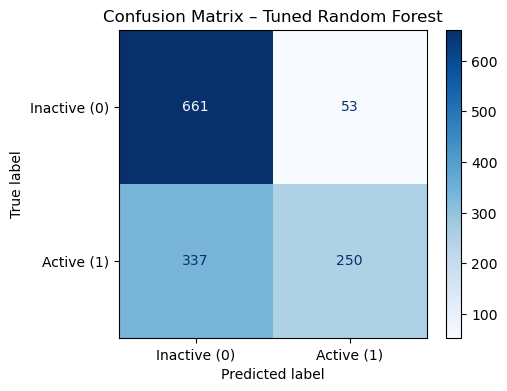

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Inactive (0)", "Active (1)"])
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(cmap="Blues", ax=ax, values_format='d')
plt.title("Confusion Matrix – Tuned Random Forest")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


#### **5.3.2 Precision–Recall Curve**

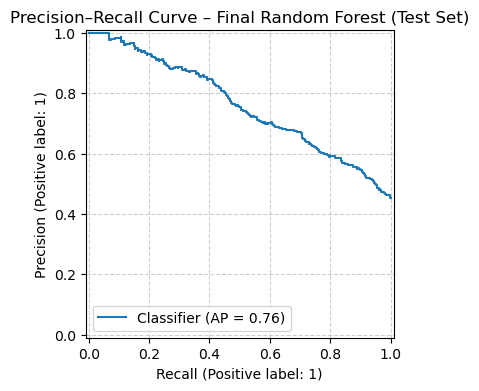

In [46]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 4))

pr_disp = PrecisionRecallDisplay.from_predictions(
    y_test,
    y_proba,   # <-- use your probability vector for class 1
    ax=ax
)

plt.title("Precision–Recall Curve – Final Random Forest (Test Set)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("precision_recall_curve.png", dpi=300, bbox_inches="tight")
plt.show()


**Precision–Recall Analysis.**  
The Precision–Recall curve highlights the conservative behavior of the Random Forest model on the scaffold-held-out test set. High precision is achieved at low recall values, indicating that predictions labeled as mutagenic are reliable. As recall increases, precision gradually decreases, reflecting the expected trade-off between sensitivity and false positives in toxicity prediction. The average precision (AP = 0.76) confirms robust performance on a challenging Ames mutagenicity task under chemically realistic generalization conditions.
